In [ ]:
pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 5.1 MB/s eta 0:00:00


In [ ]:
pip install qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 30.3 MB/s eta 0:00:00


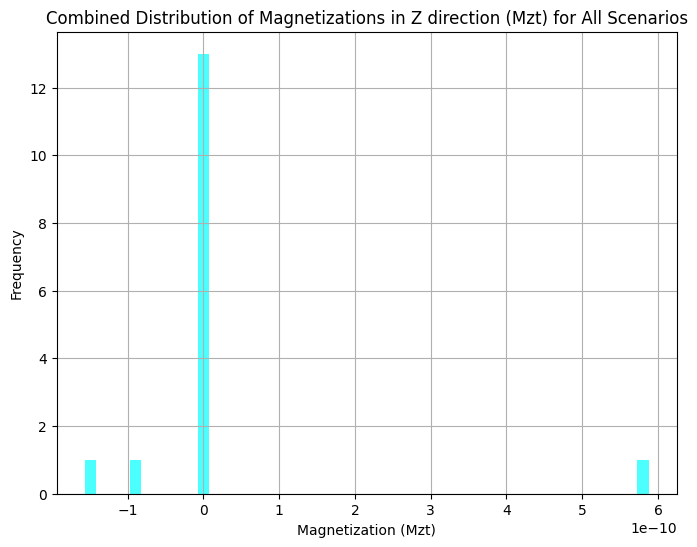

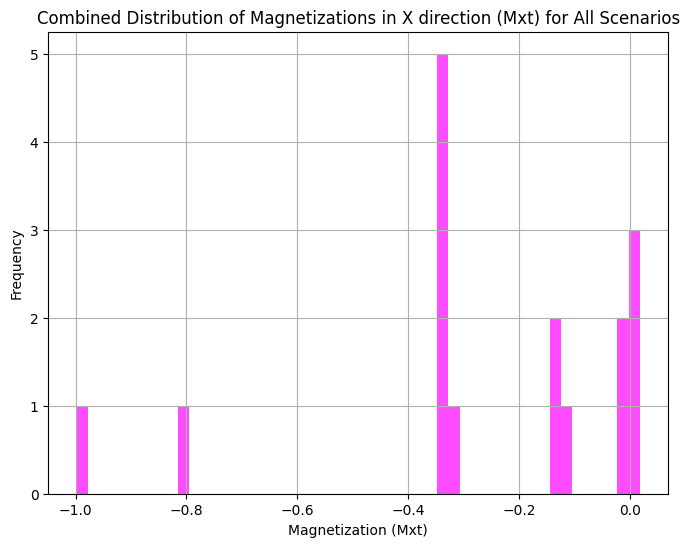

Training set size: (11, 8)
Validation set size: (2, 8)
Test set size: (3, 8)


In [ ]:
import numpy as np
from numba import jit, prange
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cProfile
import pstats

# --- Data Generation ---

# Parameters
num_qubits = 3  # Number of spins
matrix_size = 2 ** num_qubits
num_repetitions = 2  # Total data points per scenario

@jit(nopython=True, parallel=True)
def calculate_H_value(num_qubits, matrix_size, K, J, g, h):
    matrix = np.zeros((matrix_size, matrix_size))
    for i in prange(matrix_size):
        for j in prange(matrix_size):
            H_value = 0
            for i1 in prange(num_qubits):
                for j1 in prange(num_qubits):
                    if j == i ^ (2 ** i1 + 2 ** j1):
                        H_value += K[i1, j1]
                    if j == i:
                        sign = 1
                        if (i & 2 ** i1) != 0:
                            sign = -sign
                        if (i & 2 ** j1) != 0:
                            sign = -sign
                        H_value += sign * J[i1, j1]

            for i1 in prange(num_qubits):
                if j == i ^ (2 ** i1):
                    H_value += g[i1]

            if j == i:
                H_value += h
            matrix[i, j] = H_value
    return matrix

@jit(nopython=True, parallel=True)
def calculate_Mzt_and_Mxt(eigenvectors_matrix, num_qubits):
    Mzt = np.zeros(eigenvectors_matrix.shape[1])
    Mxt = np.zeros(eigenvectors_matrix.shape[1])

    for column in prange(eigenvectors_matrix.shape[1]):
        i = 0
        Mz = 0
        Mx = 0
        for component in eigenvectors_matrix[:, column]:
            for n_prime in prange(num_qubits):
                if (2 ** n_prime) & i != 0:  # Magnetization in Z direction
                    Mz += component * component / num_qubits
                if i & (1 << n_prime):  # Magnetization in X direction
                    flip_state = i ^ (1 << n_prime)  # Flip nth spin in X direction
                    Mx += component * eigenvectors_matrix[flip_state, column] / num_qubits
            i += 1
        Mzt[column] = 2 * Mz - 1
        Mxt[column] = 2 * Mx.real  # Only the real part is relevant for Mx
    return Mzt, Mxt

# Aggregated lists for all scenarios
all_eigenvectors = []
all_Mzt = []
all_Mxt = []

# Main data generation loop for different scenarios
for scenario in range(8):
    eigenvalues = []
    eigenvectors = []

    for repetition in range(num_repetitions):
        np.random.seed(repetition)

        # Define parameter ranges based on the scenario
        if scenario == 0:  # J is large
            J_range = (-20, 20)
            K_range = (-0.02, 0.02)
            g_range = (-0.02, 0.02)
            h_range = (-0.1, 0.1)
        elif scenario == 1:  # K is large
            J_range = (-0.02, 0.02)
            K_range = (-10, 10)
            g_range = (-1, 1)
            h_range = (-0.02, 0.02)
        elif scenario == 2:  # h is large
            J_range = (-1, 1)
            K_range = (-0.1, 0.1)
            g_range = (-0.02, 0.02)
            h_range = (-1, 1)
        elif scenario == 3:  # g is large
            J_range = (-0.1, 0.1)
            K_range = (-0.1, 0.1)
            g_range = (-1, 1)
            h_range = (-0.02, 0.02)
        elif scenario == 4:  # K and h are large
            J_range = (-0.1, 0.1)
            K_range = (-10, 10)
            g_range = (-0.02, 0.02)
            h_range = (-1, 1)
        elif scenario == 5:  # J and g are large
            J_range = (-20, 20)
            K_range = (-1, 1)
            g_range = (-10, 10)
            h_range = (-0.1, 0.1)
        elif scenario == 6:  # h and J are large
            J_range = (-20, 20)
            K_range = (-0.1, 0.1)
            g_range = (-0.02, 0.02)
            h_range = (-1, 1)
        else:  # All are large
            J_range = (-20, 20)
            K_range = (-10, 10)
            g_range = (-10, 10)
            h_range = (-5, 5)

        J = np.random.uniform(low=J_range[0], high=J_range[1], size=(num_qubits, num_qubits))
        for i in range(num_qubits):
            for j in range(num_qubits):
                if i >= j:
                    J[i, j] = 0
        J = (J + J.T)

        K = np.random.uniform(low=K_range[0], high=K_range[1], size=(num_qubits, num_qubits))
        for i in range(num_qubits):
            for j in range(num_qubits):
                if i >= j:
                    K[i, j] = 0
        K = (K + K.T)

        h = np.random.uniform(low=h_range[0], high=h_range[1])
        g = np.random.uniform(low=g_range[0], high=g_range[1], size=num_qubits)

        # Create H matrix
        matrix = calculate_H_value(num_qubits, matrix_size, K, J, g, h)

        eigenval, eigenvect = np.linalg.eigh(matrix)
        min_eigenval = np.min(eigenval)
        min_eigenvec = eigenvect[:, np.argmin(eigenval)]

        eigenvalues.append(min_eigenval)
        eigenvectors.append(min_eigenvec)

    eigenvectors_matrix = np.column_stack(eigenvectors)
    Mzt, Mxt = calculate_Mzt_and_Mxt(eigenvectors_matrix, num_qubits)

    # Append the results from this scenario to the aggregated lists
    all_eigenvectors.extend(eigenvectors)
    all_Mzt.extend(Mzt)
    all_Mxt.extend(Mxt)

"""
    # Plotting the distribution of magnetizations for the current scenario
    plt.figure(figsize=(8, 6))
    plt.hist(Mzt, bins=50, color='cyan', alpha=0.7)
    plt.title(f'Scenario {scenario}: Distribution of Magnetizations in Z direction (Mzt)')
    plt.xlabel('Magnetization (Mzt)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.hist(Mxt, bins=50, color='magenta', alpha=0.7)
    plt.title(f'Scenario {scenario}: Distribution of Magnetizations in X direction (Mxt)')
    plt.xlabel('Magnetization (Mxt)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
"""

# Convert to numpy arrays for plotting
all_Mzt = np.array(all_Mzt)
all_Mxt = np.array(all_Mxt)

# Plotting the combined distribution of magnetizations in Z direction
plt.figure(figsize=(8, 6))
plt.hist(all_Mzt, bins=50, color='cyan', alpha=0.7)
plt.title('Combined Distribution of Magnetizations in Z direction (Mzt) for All Scenarios')
plt.xlabel('Magnetization (Mzt)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plotting the combined distribution of magnetizations in X direction
plt.figure(figsize=(8, 6))
plt.hist(all_Mxt, bins=50, color='magenta', alpha=0.7)
plt.title('Combined Distribution of Magnetizations in X direction (Mxt) for All Scenarios')
plt.xlabel('Magnetization (Mxt)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

from sklearn.model_selection import train_test_split

# Shuffle the data
combined_data = list(zip(all_eigenvectors, all_Mzt))
np.random.shuffle(combined_data)
features, labels = zip(*combined_data)
features = np.array(features)
labels = np.array(labels)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)


Epoch 1/2, Train Loss: 0.9999999999216854, Validation Loss: 1.0000000000918077
Epoch 2/2, Train Loss: 0.9999999998644197, Validation Loss: 1.000000000091806


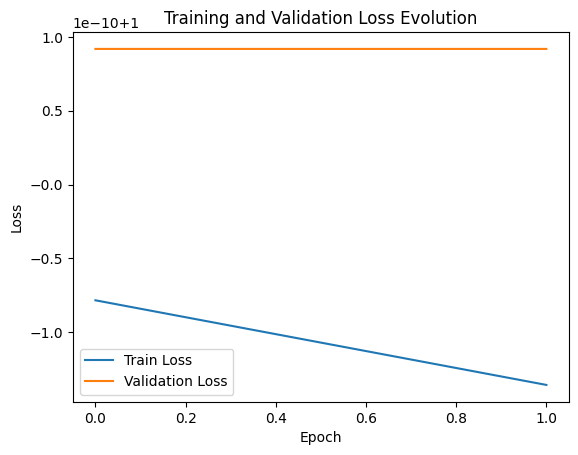

Test Loss: 0.9999999999999923


In [ ]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

class AdamOptimizer:
    def __init__(self, model, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.model = model
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None
        self.v = None
        self.t = 0

    def compute_gradient(self, features, ansatz, num_qubits, labels):
        if self.m is None:
            self.m = np.zeros(len(ansatz.parameters))
            self.v = np.zeros(len(ansatz.parameters))

        gradient = np.zeros(len(ansatz.parameters))

        weight_params = ansatz.parameters
        param_values = self.model.param_values

        # Calculate gradients using the parameter shift rule
        for param_index, param in enumerate(weight_params):
            # Shift the parameter positively and negatively
            shifted_params_pos = param_values.copy()
            shifted_params_neg = param_values.copy()

            shifted_params_pos[param] += np.pi / 2
            shifted_params_neg[param] -= np.pi / 2

            # Compute output and loss for both parameter shifts
            output_pos = self.model.forward(features, ansatz, num_qubits, shifted_params_pos)
            output_neg = self.model.forward(features, ansatz, num_qubits, shifted_params_neg)

            loss_pos = self.model.mse_loss(output_pos, labels)
            loss_neg = self.model.mse_loss(output_neg, labels)

            # Calculate the gradient using the parameter shift rule
            gradient[param_index] = (loss_pos - loss_neg) / 2

        # Update biased first and second moments
        self.t += 1
        self.m = self.beta1 * self.m + (1 - self.beta1) * gradient
        self.v = self.beta2 * self.v + (1 - self.beta2) * (gradient ** 2)

        # Bias correction
        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)

        # Update parameters
        delta_params = -self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

        # Apply parameter updates
        for param_index, param in enumerate(weight_params):
            param_values[param] += delta_params[param_index]

        return param_values

class QuantumCNNModel:
    def __init__(self, num_qubits, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.num_qubits = num_qubits
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.circuit, self.parameters = self.build_qnn(num_qubits)
        self.optimizer = AdamOptimizer(self, learning_rate, beta1, beta2, epsilon)
        self.param_values = {param: np.random.uniform(0, 2*np.pi) for param in self.parameters}

    def build_qnn(self, num_qubits):
        qreg_q = QuantumRegister(num_qubits, 'q')
        ansatz = QuantumCircuit(qreg_q)
        ansatz.h(range(num_qubits))

        cnot_pairs = [(i, i+1) for i in range(0, num_qubits-1, 2)]
        cnot_pairs += [(i, i+1) for i in range(1, num_qubits-1, 2)]

        parameters = []
        layer = 3
        for i in range(layer):
            for j, (control, target) in enumerate(cnot_pairs):
                theta = Parameter(f'theta_{i}_{j}')
                phi = Parameter(f'phi_{i}_{j}')
                lam = Parameter(f'lam_{i}_{j}')
                gamma = Parameter(f'gamma_{i}_{j}')
                parameters += [theta, phi, lam, gamma]

                ansatz.cu(theta, phi, lam, gamma, qreg_q[control], qreg_q[target])

        return ansatz, parameters

    def forward(self, features, ansatz, num_qubits, param_bindings):
        output_list = []

        for state_vector in features:
            qc = QuantumCircuit(num_qubits)
            qc.initialize(state_vector, range(num_qubits))
            qc.compose(ansatz, inplace=True)
            cr = ClassicalRegister(1, name="c")
            qc.add_register(cr)
            #qc.measure(num_qubits - 1, cr[0]) # Measure last qubit of the circuit
            middle_qubit = num_qubits // 2 # Measure the middle qubit of the circuit
            qc.measure(middle_qubit, cr[0])

            bound_qc = qc.assign_parameters(param_bindings)

            backend = AerSimulator()
            job = backend.run(bound_qc, shots=1)
            result = job.result()
            counts = result.get_counts(bound_qc)

            if '0' in counts and '1' in counts:
                exp_val = (counts['0'] - counts['1']) / sum(counts.values())
            elif '0' in counts:
                exp_val = counts['0'] / sum(counts.values())
            else:
                exp_val = -counts['1'] / sum(counts.values())

            output_list.append(exp_val)

        return output_list

    def mse_loss(self, output, labels):
        return np.mean(np.square(np.array(labels) - np.array(output)))

    def evaluate(self, features, labels):
        output = self.forward(features, self.circuit, self.num_qubits, self.param_values)
        loss = self.mse_loss(output, labels)
        return loss

    def predict(self, features):
        predictions = self.forward(features, self.circuit, self.num_qubits, self.param_values)
        return predictions

    def train(self, train_features, train_labels, val_features, val_labels, num_epochs):
        loss_history = []  # Initialize loss history
        val_loss_history = []  # Initialize validation loss history

        for epoch in range(num_epochs):
            # Training step
            output = self.forward(train_features, self.circuit, self.num_qubits, self.param_values)
            train_loss = self.mse_loss(output, train_labels)
            self.param_values = self.optimizer.compute_gradient(train_features, self.circuit, self.num_qubits, train_labels)

            # Validation step
            val_loss = self.evaluate(val_features, val_labels)

            # Append losses to history
            loss_history.append(train_loss)
            val_loss_history.append(val_loss)

            print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

        # Plot the training and validation loss
        plt.plot(loss_history, label='Train Loss')
        plt.plot(val_loss_history, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Evolution')
        plt.legend()
        plt.show()

        # Return final validation loss for further evaluation
        return val_loss

    def test(self, test_features, test_labels):
        test_loss = self.evaluate(test_features, test_labels)
        print(f"Test Loss: {test_loss}")
        return


# ---------Run the code--------

# Create the model
model = QuantumCNNModel(num_qubits=num_qubits)

# Predictions on test set
predictions = model.predict(X_test)

# Train the model
val_loss = model.train(X_train, y_train, X_val, y_val, num_epochs=2)

# Test the model
test_loss = model.test(X_test, y_test)
